In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import lmfit as lm
import scipy as sp
import corner
import emcee
import pandas as pd
from lc_lmfit import *

In [2]:
folder='afterglow_data/'
filename='_xray_flux.txt'

GRBs=['050724', '051227', '060614', '061006', '061210', '070714B', '071227', '080123', '080503', '111121A', '150424A', '211211A', '211227A']

### Extracting and Plotting Curves


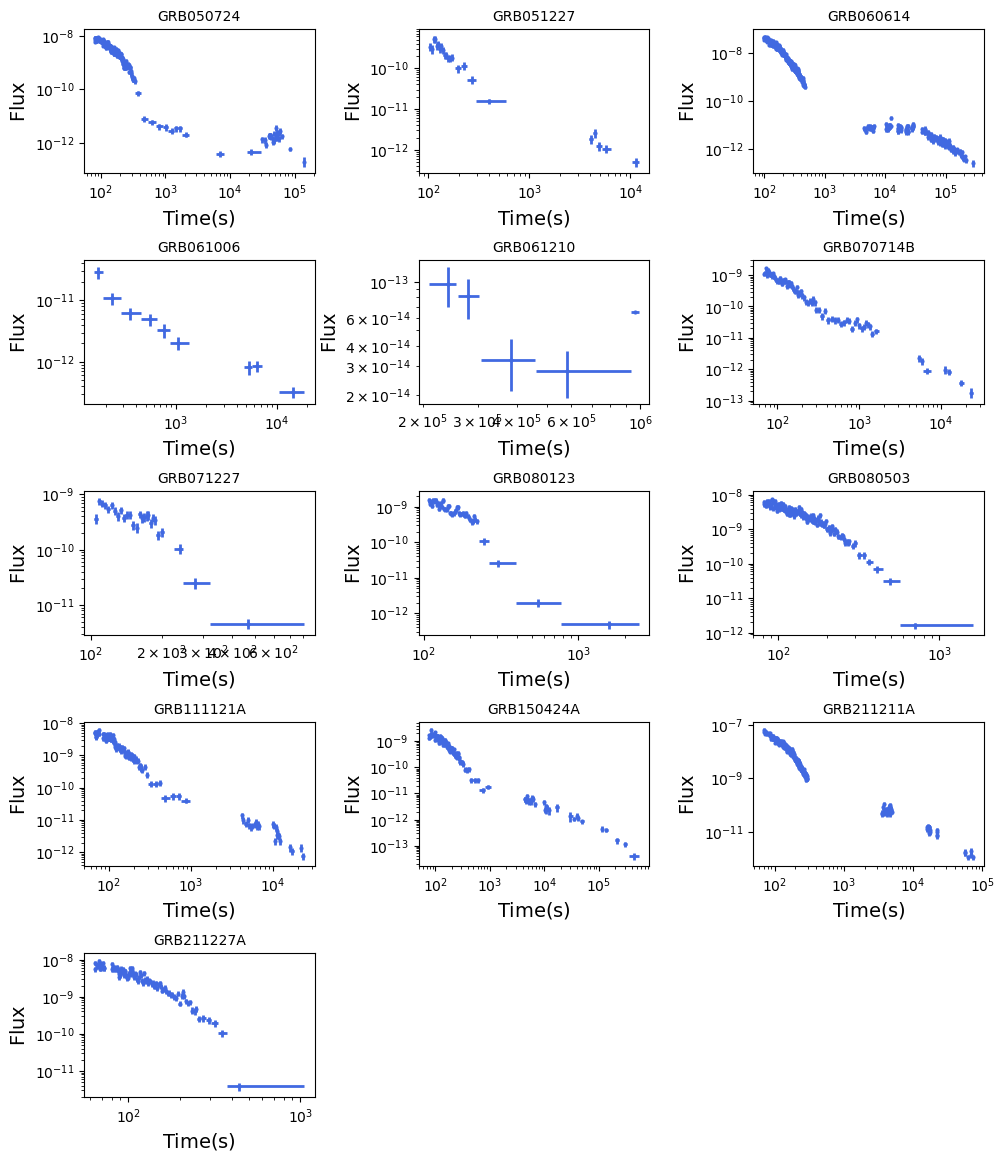

In [3]:
fig=plt.figure(figsize=(10.0,12.0), dpi=100)
fig.patch.set_facecolor('white')
plt.subplots_adjust(top=0.96, bottom=0.07, left=0.07, right=0.97, hspace=0.6,wspace=0.45)

for i in range(len(GRBs)):
    ax1 = fig.add_subplot(5,3, i+1)
    Time,Time_high,Time_low,Flux,Flux_high,Flux_low=get_individual_curves_log(folder+GRBs[i]+filename)
    ax1.errorbar(Time,Flux,xerr=[Time_low,Time_high],yerr=[Flux_low,Flux_high],fmt='.',color='royalblue',linewidth=2.0,markersize=4.0)
    plt.gca().set_xscale("log")
    plt.gca().set_yscale("log")
    #ax1.set_xlim(1e1,1e5)
    #ax1.set_ylim(1e-14,1e-9)
    ax1.set_xlabel('$\mathrm{Time(s)}$',fontsize=14.)
    ax1.set_ylabel('$\mathrm{Flux}$',fontsize=14.)
    ax1.set_title("GRB"+GRBs[i],fontsize=10)

#xticks = ticker.LogLocator(numticks=4)
#ax1.xaxis.set_minor_locator(xticks)
#ax1.tick_params(axis='x', which='minor', labelsize=7.0)

plt.show()

### GRB i=1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 5
    # data points      = 0
    # variables        = 4
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be estimated:
    t_break:    at initial value
    alpha_1:    at initial value
    alpha_2:    at initial value
    amplitude:  at initial value
    amplitude:  at boundary
[[Variables]]
    t_break:    55000.0000 (init = 55000)
    alpha_1:   -1.20000000 (init = -1.2)
    alpha_2:    2.20000000 (init = 2.2)
    amplitude:  5.4000e-12 (init = 2e-12)


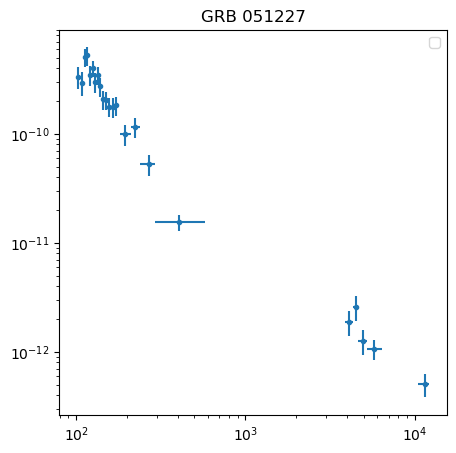

In [8]:
i=1
time,time_high,time_low,flux,flux_high,flux_low =get_individual_curves_log(folder+GRBs[i]+filename)
flux_err = flux_high + flux_low
time_err = time_high + time_low

fit_index = 211

params=lm.Parameters()
params.add("t_break", min = 4e4, max = 6e4, value = 5.5e4)
params.add("alpha_1", min = -5.0, max = 5.0, value = -1.2)
params.add("alpha_2", min = 0, max = 5.0, value = 2.2)
params.add("amplitude", min = 8e-13, max = 1e-11, value = 2e-12)

minner = lm.Minimizer(cost_func_bpl, params, fcn_args=(time[fit_index:], flux[fit_index:], time_err[fit_index:], flux_err[fit_index:]))
result = minner.minimize(method="least_squares")

bfit = result.params
tb = bfit["t_break"].value
alp1 = bfit["alpha_1"].value
alp2 = bfit["alpha_2"].value
amp = bfit["amplitude"].value

lm.printfuncs.report_fit(result)


x1=np.linspace(1e4,1.4e5,500)
fig=plt.figure(figsize=(5.0,5.0), dpi=100)
plt.errorbar(time, flux, fmt='.', xerr=[time_low,time_high],yerr=[flux_low,flux_high])
# plt.plot(x1,broken_power_law(x1,tb, alp1, alp2, amp),label ='best fit')
#plt.errorbar(time[fit_index:], flux[fit_index:], fmt='o')
#plt.plot(x1,broken_power_law(x1,55000, -1.2, 2.2, 2e-12),label ='best fit')
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.title("GRB "+GRBs[i])
plt.show()

### Initial Emission

[[Fit Statistics]]
    # fitting method   = differential_evolution
    # function evals   = 1542
    # data points      = 23
    # variables        = 2
    chi-square         = 25.4122979
    reduced chi-square = 1.21010942
    Akaike info crit   = 6.29399724
    Bayesian info crit = 8.56498567
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    alpha_1:    2.32338691 (init = 2.7)
    amplitude:  2.2753e-05 (init = 0.001)


<Figure size 800x800 with 0 Axes>

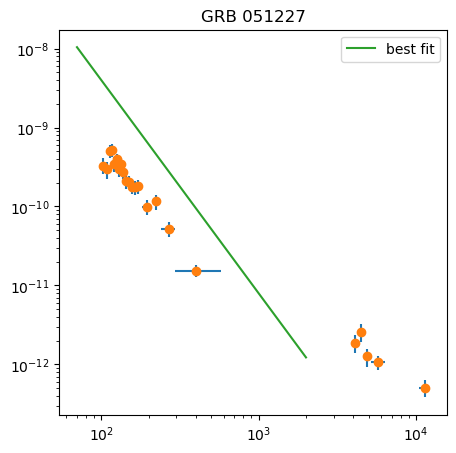

In [5]:
i=1
fig=plt.figure(figsize=(8.0,8.0), dpi=100)
fig.patch.set_facecolor('white')

fit_index = 211
params_ini=lm.Parameters()
params_ini.add("alpha_1", min = 0, max = 10.0, value = 2.7)
params_ini.add("amplitude", min = 1e-6, max = 1, value = 1e-3)

minner_ini = lm.Minimizer(cost_func_pl, params_ini, fcn_args=(time[:fit_index], flux[:fit_index], time_err[:fit_index], flux_err[:fit_index]))
result_ini = minner_ini.minimize(method="differential_evolution")

bfit_ini = result_ini.params
alp1_ini = bfit_ini["alpha_1"].value
amp_ini = bfit_ini["amplitude"].value

lm.printfuncs.report_fit(result_ini)

x1=np.linspace(7e1,2e3,30)
fig=plt.figure(figsize=(5.0,5.0), dpi=100)
plt.errorbar(time, flux, fmt='.', xerr=[time_low,time_high],yerr=[flux_low,flux_high])
# plt.plot(x1,power_law(x1,alp1_ini, amp_ini),label ='best fit')
plt.errorbar(time[:fit_index], flux[:fit_index], fmt='o')
plt.plot(x1,power_law(x1, 2.7, 1e-3),label ='best fit')
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.title("GRB "+GRBs[i])
plt.show()

### nbroken law

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 77
    # data points      = 23
    # variables        = 10
    chi-square         = 30.5221656
    reduced chi-square = 2.34785890
    Akaike info crit   = 26.5080558
    Bayesian info crit = 37.8629979
##  Warning: uncertainties could not be estimated:
    alpha_4:    at initial value
    amplitude:  at initial value
    amplitude:  at boundary
[[Variables]]
    tb0:        216.402881 (init = 250)
    tb1:        268.980790 (init = 450)
    tb2:        12733.0489 (init = 10000)
    tb3:        89750.0000 (init = 63000)
    alpha_0:   -0.37999431 (init = 2)
    alpha_1:    9.26611276 (init = 8)
    alpha_2:    0.96967475 (init = 1)
    alpha_3:   -0.00149228 (init = -1.2)
    alpha_4:    2.50000000 (init = 2.5)
    amplitude:  2.3758e-10 (init = 8e-10)


name,value,initial value,min,max,vary
tb0,216.402881,250.0,100.000000,1000.00000,True
tb1,268.980790,450.0,100.000000,1000.00000,True
tb2,12733.0489,10000.0,5000.00000,50000.0000,True
tb3,89750.0000,63000.0,40000.0000,90000.0000,True
alpha_0,-0.37999431,2.0,-10.0000000,10.0000000,True
alpha_1,9.26611276,8.0,-10.0000000,20.0000000,True
alpha_2,0.96967475,1,-100.000000,100.000000,True
alpha_3,-0.00149228,-1.2,-5.00000000,0.00000000,True
alpha_4,2.50000000,2.5,0.00000000,10.0000000,True
amplitude,2.3758e-10,8e-10,1.0000e-10,5.0000e-09,True


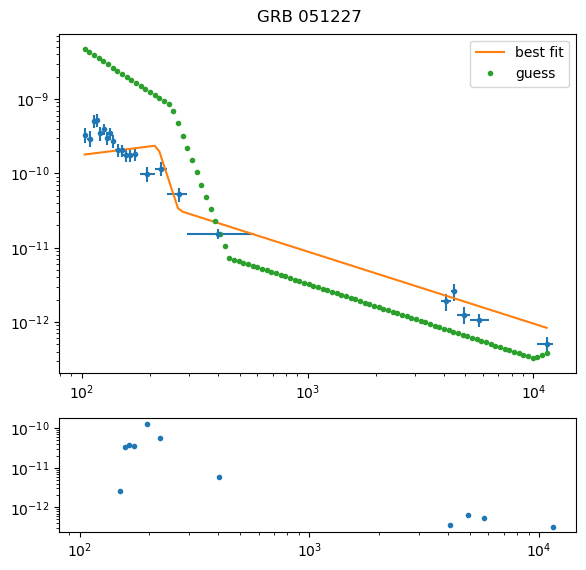

In [6]:
i=1
time,time_high,time_low,flux,flux_high,flux_low =get_individual_curves_log(folder+GRBs[i]+filename)
flux_err = flux_high + flux_low
time_err = time_high + time_low

fit_index = 0
n=5
params=lm.Parameters()
params.add("tb0", min = 1e2, max = 1e3, value = 2.5e2)
params.add("tb1", min = 1e2, max = 1e3, value = 4.5e2)
# params.add("tb2", min = 1e3, max = 5e3, value = 2e3)
params.add("tb2", min = 5e3, max = 5e4, value = 1e4)
params.add("tb3", min = 4e4, max = 9e4, value = 6.3e4)
params.add("alpha_0", min = -10, max = 10.0, value = 2.0)
params.add("alpha_1", min = -10, max = 20.0, value = 8.0)
params.add("alpha_2", min = -100, max = 100, value = 1)
# params.add("alpha_3", min = -100, max = 100, value = 1.4)
params.add("alpha_3", min = -5.0, max = 0, value = -1.2)
params.add("alpha_4", min = 0, max = 10.0, value = 2.5)
params.add("amplitude", min = 1e-10, max = 5e-9, value = 8e-10)

minner = lm.Minimizer(cost_func_nbpl, params, fcn_args=(time[fit_index:], flux[fit_index:], time_err[fit_index:], flux_err[fit_index:], n), fcn_kws={"orth":False})
result = minner.minimize(method="least_squares")
lm.printfuncs.report_fit(result)

residuals = get_y(result, n, time) - flux

x = np.geomspace(time[0],time[-1],100)
fig, (ax1, ax2) = plt.subplots(2, figsize=(20/3, 6), height_ratios=[3,1])
ax1.errorbar(time, flux, fmt='.', xerr=[time_low,time_high],yerr=[flux_low,flux_high])
ax1.loglog(x, get_y(result, n, x),label ='best fit')
# ax1.loglog(x, nbroken_law(x, [2.5e2, 5e2, 2e3, 1.5e4, 5.5e4], [2, 8.0, -0.2, 1.4, -2.2, 3.0], 8e-11),'.',label ='guess')
ax1.loglog(x, nbroken_law(x, [2.5e2, 4.5e2, 1e4, 5.5e4], [2, 8.0, 1, -1.2, 2.5], 8e-10),'.',label ='guess')
ax1.legend()
ax2.loglog(time,residuals, '.')
plt.subplots_adjust(top=0.94)
plt.suptitle("GRB "+GRBs[i])

result.params

In [7]:
result.params.valuesdict()

{'tb0': 216.4028805100043,
 'tb1': 268.98079002191196,
 'tb2': 12733.048864163484,
 'tb3': 89750.0,
 'alpha_0': -0.3799943075790182,
 'alpha_1': 9.266112756159503,
 'alpha_2': 0.9696747530177934,
 'alpha_3': -0.001492282436367496,
 'alpha_4': 2.5,
 'amplitude': 2.3757940849660904e-10}